# Species Distribution Modeling with Neural Networks<br><sub>Author: Greg Holste<br></sub>

## Introduction

In this notebook, we'll use feedforward artifical neural networks to model the distribution of *Solanum commersonii*, a wild relative of the potato. The basic idea is to train a classifier to distinguish species presences and absences based on the climatic features of those locations. **See [this notebook](https://github.com/holste1/topics-in-ml/blob/master/02_CART%2BBoosting/03_SDM-Application.ipynb) – where we used boosting methods for species distribution modeling (SDM) – for more details before continuing!**

We'll first use our basic implementation of a neural network, then use Tensorflow (Google's powerful open-source deep learning library) to introduce some techniques for improving performance by reducing the risk of overfitting. Again, we'll hop back and forth between R and Python for plotting and modeling, respectively.

## Data Preparation

Run R script that essentially repeats the data wrangling and cleaning done in the linked notebook above.

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
source("get_sdm_data.R")

Remind ourselves of the data: *S. commersonii* presences and random "background" psuedoabsences.

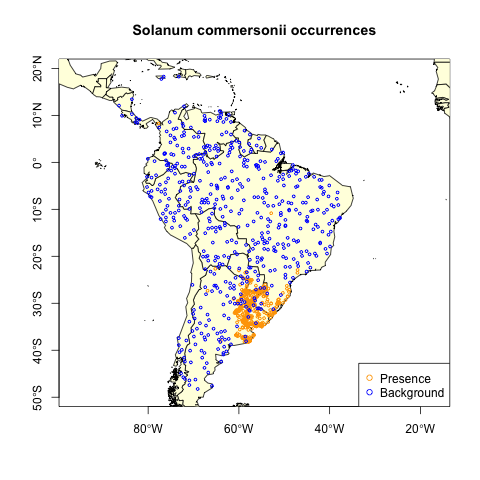

In [3]:
%%R
data(wrld_simpl)
plot(wrld_simpl,
     xlim = c(min(sdm_data$lon) + 10, max(sdm_data$lon) + 1),
     ylim = c(min(sdm_data$lat) - 1, max(sdm_data$lat) + 1),
     col = "light yellow",
     axes = T)
points(species$lon, species$lat, col = "orange", pch = 21, cex = 0.5)
points(bg[, 1], bg[, 2], col = "blue", pch = 21, cex = 0.5)
legend("bottomright",
       legend = c("Presence", "Background"),
       pch = 21,
       col = c("orange", "blue"),
       cex = 1)
title("Solanum commersonii occurrences")

Switch to Python and read in the bioclimatic data for our *S. commersonii* presences/psuedoabsences.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from ANN import *  # import custom neural net implementation

import os
import random
import numpy as np
import tensorflow as tf

# for reproducibility...
os.environ['PYTHONHASHSEED'] = str(0)
random.seed(0)
np.random.seed(0)
tf.compat.v1.set_random_seed(0)

In [5]:
sdm_data = pd.read_csv("Data/S_commersonii_sdm_data.csv")
sdm_data.head()

,Presence,lon,lat,bio1,bio2,bio3,bio4,bio5,bio6,bio7,...,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,1,-49.448611,-26.286389,0.650704,0.395210,0.303571,0.458320,0.644013,0.587530,0.482394,...,0.689655,0.611675,0.146027,0.178571,0.124233,0.097561,0.172228,0.129226,0.196127,0.103696
1,1,-49.410833,-26.910000,0.704225,0.353293,0.267857,0.454297,0.711974,0.654676,0.457746,...,0.746082,0.662437,0.158532,0.182653,0.138037,0.085366,0.181198,0.137101,0.206428,0.113742
2,1,-53.000000,-33.000000,0.670423,0.311377,0.160714,0.546025,0.708738,0.630695,0.489437,...,0.730408,0.614213,0.120714,0.115306,0.131902,0.036585,0.116972,0.126447,0.124021,0.114101
3,1,-47.102222,-23.515556,0.667606,0.365269,0.392857,0.348729,0.608414,0.618705,0.397887,...,0.680251,0.644670,0.152985,0.254082,0.070552,0.227642,0.246143,0.069013,0.265760,0.053463
4,1,-47.060800,-22.905600,0.729577,0.443114,0.446429,0.359511,0.682848,0.645084,0.440141,...,0.739812,0.695431,0.132211,0.226531,0.039877,0.256098,0.224973,0.047244,0.258344,0.036598


Notice all the bioclimatic variables are decimal-valued. In `get_sdm_data.R`, we have actually **normalized** each feature, meaning we have rescaled each predictor by mapping it onto the interval $[0, 1]$. This ensures each feature is on the same scale, regardless of units, and is a standard pre-processing step for neural networks. The idea is it leads to faster convergence and avoid "neuron saturation" [CITE?].

We then **one-hot encode** our labels (presence *vs.* pseudoabsence). This means that every $1$ (presence) becomes $(0, 1)$ and every $-1$ (pseudoabsence) becomes $(1, 0)$. One can interpret these one-hot encoded labels as **vectors where each element is a binary indicator of class membership**. For example, $Y = (0, 1)$ means that the observation does *not* belong to class 0 and *does* belong to class 1.

In [6]:
X = sdm_data.drop(["Presence", "lon", "lat"], axis=1).to_numpy()
Y = sdm_data["Presence"].ravel()
Y[Y == -1] = 0
Y = np.array([np.squeeze(one_hot(y, 2)) for y in Y])  # one-hot encode

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (1054, 19)
Y shape: (1054, 2)


Split into training and testing sets (the same as in the previous SDM notebook!). Then, we must prepare the data for our particular neural net implementation in `ANN.py`. Specifically, the data must be represented as a list of $({\bf x}, {\bf y})$ tuples.

In [7]:
N = X.shape[0]
np.random.seed(0)
test_idxs = np.random.choice(range(N), size=int(0.2 * N), replace=False)
non_test_idxs = np.array(list(set(range(N)).difference(set(test_idxs))))

testing_data = [(x[:, np.newaxis], y[:, np.newaxis]) for x, y in zip(X[test_idxs, :], Y[test_idxs, :])]
training_data = [(x[:, np.newaxis], y[:, np.newaxis]) for x, y in zip(X[non_test_idxs, :], Y[non_test_idxs, :])]

print(len(training_data), "training observations")
print(len(testing_data), "testing observations")

844 training observations
210 testing observations


## Simple Neural Network

Create a neural network with a single hidden layer of 64 neurons, specifying that our output is discrete (we are performing classification).

In [8]:
NN = NeuralNet([X.shape[1], 64, 2], y_type="discrete")

Train for $500$ epochs on mini-batches of $50$ observations at a time using stochastic gradient descent with a learning rate of $1$. These parameters are chosen arbitrarily, but later we'll introduce a method to choose the number of epochs.

In [9]:
NN.train(training_data, batch_size=50, epochs=500, lr=1.)

Epoch 500 | Accuracy: 0.954: 100%|██████████| 500/500 [00:30<00:00, 16.39it/s]


We see by the end of training, our model achieves $95.4\%$ accuracy. Now how does it perform on the test set?

In [10]:
print(f"{round(NN.evaluate(testing_data) * 100, 3)}% test accuracy")

96.19% test accuracy


This is the best test accuracy we have seen! **In terms of overall accuracy on the test set, this neural net ($96.19\%$) outperforms CART ($92.38\%$), AdaBoost ($94.29\%$), and GBRT ($93.81\%$)**.

However, this does not necessarily mean our neural net produces a *better* model of the *S. commersonii* distribution. Before visualiziing predictions, let's look at a confusion matrix to analyze the types of errors our model is making.

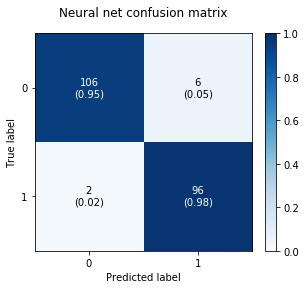

In [11]:
y_pred = NN.predict([x for x, _ in testing_data])
y_true = np.array([np.argmax(y) for _, y in testing_data])

cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(cm, show_normed=True, colorbar=True)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Neural net confusion matrix")
# fig.savefig("Figs/CM_NN.png", dpi=600, bbox_inches="tight")
plt.show()

## Simple Neural Net: Visualize Predictions

Now let's read in the normalized bioclimatic data for all cells in our model environment, then convert it to the proper format for our neural net implementation.

In [12]:
env_data = pd.read_csv("Data/norm_env_data.csv")
env_data.head()

,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,0.918310,0.221557,0.607143,0.126971,0.812298,0.918465,0.179577,0.946835,0.854599,0.899687,0.913706,0.159036,0.226531,0.073620,0.195122,0.211697,0.072719,0.223733,0.060280
1,0.915493,0.203593,0.607143,0.122948,0.805825,0.923261,0.165493,0.944304,0.854599,0.896552,0.913706,0.183743,0.262245,0.085890,0.199187,0.243272,0.082446,0.256283,0.069609
2,0.892958,0.179641,0.589286,0.124236,0.773463,0.908873,0.151408,0.924051,0.830861,0.874608,0.893401,0.207342,0.285714,0.093558,0.199187,0.277718,0.092172,0.295426,0.075709
3,0.839437,0.179641,0.571429,0.123914,0.715210,0.863309,0.154930,0.875949,0.774481,0.815047,0.845178,0.243546,0.342857,0.102761,0.203252,0.334051,0.102362,0.348991,0.087191
4,0.836620,0.179641,0.571429,0.126810,0.711974,0.860911,0.154930,0.870886,0.768546,0.811912,0.842640,0.222570,0.314286,0.111963,0.186992,0.298529,0.106994,0.294602,0.087549


In [13]:
env_data_list = [env_data.iloc[i, :][:, np.newaxis] for i in range(env_data.shape[0])]

Make probabilistic predictions for entire model environment by passing model outputs through the [*softmax function*](https://en.wikipedia.org/wiki/Softmax_function), which maps our network's two outputs to a probability distribution (such that they sum to 1).

In [14]:
NN_probs = np.array([pred[1] for pred in NN.predict_proba(env_data_list)])

Attach these probabilities to our raster brick in R, then visualize predicted suitability plot for *S. commersonii*. Each pixel value can be interpreted as the probability that *S. commersonii* could be found in said location based on its climate.

In [15]:
%%R -i NN_probs
idx <- as.numeric(rownames(model_env_data))
NN_prob <- rep(NA, nrow(values(model_env)))
NN_prob[idx] <- NN_probs

values(model_env) <- cbind(values(model_env), NN_prob)

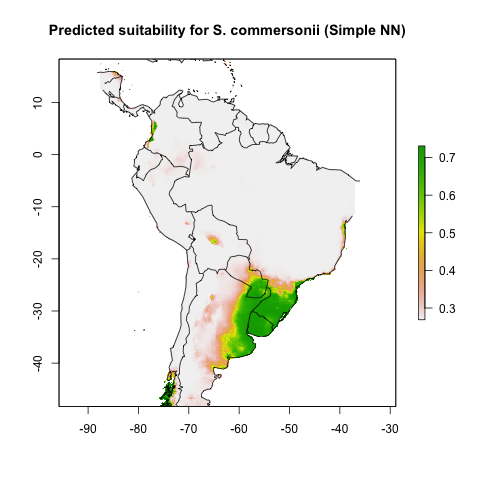

In [16]:
%%R
plot(model_env$NN_prob)
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)
title("Predicted suitability for S. commersonii (Simple NN)")

Threshold probabilities at $0.5$ to visualize the actual decisions our model would make about where *S. commersonii* could be found. We can also plot the test set observations, marked according to their true label.

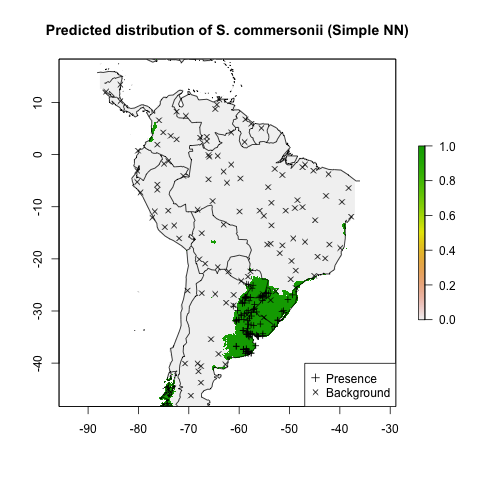

In [17]:
%%R -i test_idxs
test_idxs <- test_idxs + 1

plot(model_env$NN_prob > 0.5)
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)
points(with(sdm_data[test_idxs, ], lon[Presence == 1]),
       with(sdm_data[test_idxs, ], lat[Presence == 1]),
       pch = 3, cex = 0.75)
points(with(sdm_data[test_idxs, ], lon[Presence == -1]),
       with(sdm_data[test_idxs, ], lat[Presence == -1]),
       pch = 4, cex = 1)
legend("bottomright",
       legend = c("Presence", "Background"),
       pch = 3:4,
       cex = 1)
title("Predicted distribution of S. commersonii (Simple NN)")

## Tensorflow (TF) Neural Network

Now we will try a slightly more sophisticated neural network using Keras, a high-level API on top of Tensorflow, Google's deep learning library. Keras is very easy to use and flexible, so we can nicely introduce some tweaks to the network we used above that will hopefully improve performance even further.

For example, how do we choose the number of epochs to train for? One approach is to use **early stopping**, where we set aside a *validation set* (randomly taken from the training set), train on the remaining training data, and monitor the performance on the held-out validation set at the end of each epoch. Then we can terminate training once our metric of interest (either validation loss or something such as validation accuracy) levels off. Specifically, we will choose to terminate training when the validation accuracy does not improve for 25 epochs, then restore the weights from the epoch with the highest val acc.

In [18]:
np.random.seed(0)
val_idxs = np.random.choice(non_test_idxs, size=int(0.1 * N), replace=False)
train_idxs = np.array(list(set(non_test_idxs).difference(set(val_idxs))))

X_test, y_test = X[test_idxs, :], Y[test_idxs]
X_val, y_val = X[val_idxs, :], Y[val_idxs]
X_train, y_train = X[train_idxs, :], Y[train_idxs, :]

print(X_train.shape[0], "training observations")
print(X_val.shape[0], "validation observations")
print(X_test.shape[0], "testing observations")

739 training observations
105 validation observations
210 testing observations


Again create a neural net with a single hidden layer of 64 neurons, but this time using the [rectifier](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) activation. Our output layer also now uses a softmax activation so that our outputs can be directly interpreted as probabilities. Finally, like our example above, we use mean-squared-error (MSE) loss and train using stochastic gradient descent (SGD) with a learning rate of $1$. Notice how simple it is to build a nearly identical model to the one presented earlier (basically 4 lines of code)!

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer=VarianceScaling(seed=0), activation="relu"))
model.add(Dense(2, kernel_initializer=VarianceScaling(seed=0), activation="softmax"))

model.compile(metrics=["accuracy"], loss="mean_squared_error", optimizer=SGD(lr=1.))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1280      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________


Define our early stopping scheme and train!

In [20]:
es = EarlyStopping(monitor="val_acc", mode="max", patience=25, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=500, batch_size=50,
                    validation_data=(X_val, y_val),
                    callbacks = [es])

Train on 739 samples, validate on 105 samples
Epoch 1/500
739/739 [==============================] - 0s 352us/sample - loss: 0.2003 - acc: 0.7524 - val_loss: 0.1312 - val_acc: 0.8381
Epoch 2/500
739/739 [==============================] - 0s 32us/sample - loss: 0.1072 - acc: 0.8755 - val_loss: 0.1125 - val_acc: 0.8762
Epoch 3/500
739/739 [==============================] - 0s 36us/sample - loss: 0.0914 - acc: 0.8945 - val_loss: 0.1068 - val_acc: 0.8571
Epoch 4/500
739/739 [==============================] - 0s 34us/sample - loss: 0.0893 - acc: 0.8931 - val_loss: 0.1263 - val_acc: 0.8286
Epoch 5/500
739/739 [==============================] - 0s 42us/sample - loss: 0.0907 - acc: 0.8904 - val_loss: 0.0914 - val_acc: 0.8857
Epoch 6/500
739/739 [==============================] - 0s 37us/sample - loss: 0.0777 - acc: 0.9053 - val_loss: 0.0840 - val_acc: 0.8857
Epoch 7/500
739/739 [==============================] - 0s 33us/sample - loss: 0.0841 - acc: 0.8931 - val_loss: 0.1594 - val_acc: 0.7619
E

Notice we terminated training quite early (after only 36 epochs). Considering we trained a similar neural net earlier for 500 epochs, this suggests our first neural net was perhaps overfitting the training data.

Tensorflow conveniently tracks metrics throughout training, so let's visualize the accuracy and loss by epoch.

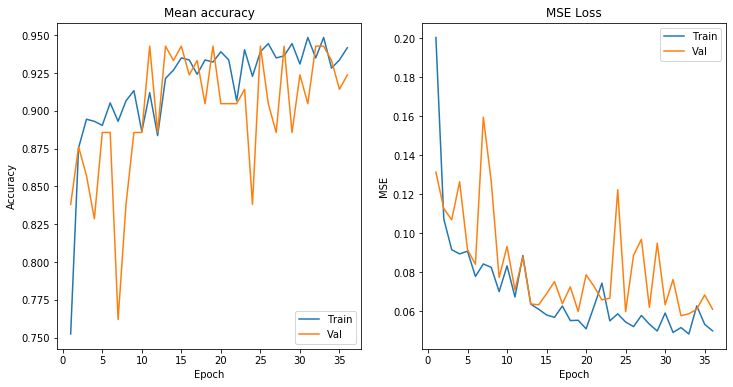

In [21]:
epochs = np.array(range(len(history.history['acc']))) + 1

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(epochs, history.history['acc'])
ax[0].plot(epochs, history.history['val_acc'])
ax[0].set_title('Mean accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Val'], loc='lower right')
ax[1].plot(epochs, history.history['loss'])
ax[1].plot(epochs, history.history['val_loss'])
ax[1].set_title('MSE Loss')
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc='upper right')

It looks like the maximum validation accuracy occurred at epoch 10, so let's confirm that.

In [22]:
print(f"Max validation accuracy: {round(np.max(history.history['val_acc']) * 100, 3)}%")
print("Restored weights from epoch", np.argmax(history.history['val_acc']))

Max validation accuracy: 94.286%
Restored weights from epoch 10


This means our model's final weights were from only 10 epochs of training. Now we can easily evaluate how this model performs on the test set:

In [23]:
print(f"{round(model.evaluate(X_test, y_test, verbose=0)[1] * 100, 3)}% test accuracy")

96.667% test accuracy


Slighly better than before! Let's look at the resulting confusion matrix.

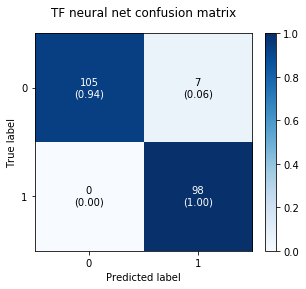

In [24]:
y_pred = np.array([np.argmax(pred) for pred in model.predict(X_test)])
y_true = np.array([np.argmax(y) for y in y_test])

cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(cm, show_normed=True, colorbar=True)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("TF neural net confusion matrix")
# fig.savefig("Figs/CM_TF_NN.png", dpi=600, bbox_inches="tight")
plt.show()

We see that this model achieves a perfect true positive rate, correctly classifying all *S. commersonii* presences, while only misclassifying $6\%$ of pseudoabsences as presences.

## TF Neural Net: Visualize Predictions

Now to actually compare the two neural nets, let's again export our predicted probabilities to R and visualize the predicted suitability for *S. commersonii*.

In [25]:
TF_probs = model.predict(env_data)[:, 1]

In [26]:
%%R -i TF_probs
idx <- as.numeric(rownames(model_env_data))
TF_prob <- rep(NA, nrow(values(model_env)))
TF_prob[idx] <- TF_probs

values(model_env) <- cbind(values(model_env), TF_prob)

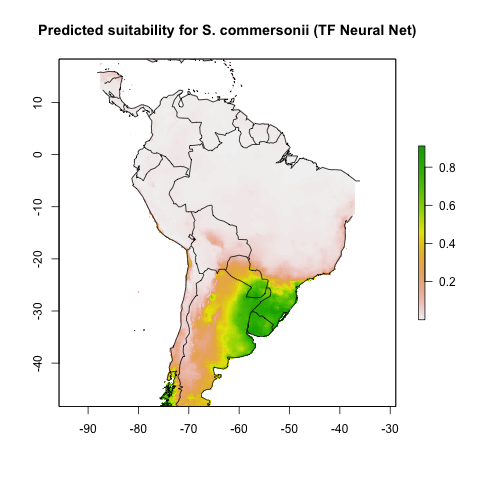

In [27]:
%%R
plot(model_env$TF_prob)
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)
title("Predicted suitability for S. commersonii (TF Neural Net)")

We essentially see two distinct bands of decreasing confidence around a "core" region where the model is quite confident *S. commersonii* can be found. The model also predicts very low suitability throughout northern South America, apart from some coastal regions with a low (but nonzero) probability of presence.

Threshold predictions at $0.5$ to view the decisions made by this model.

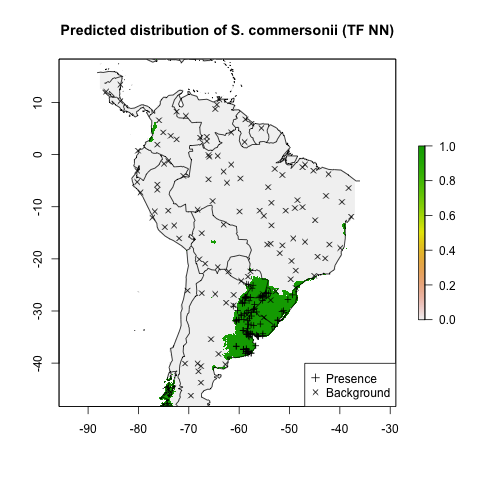

In [28]:
%%R
plot(model_env$NN_prob > 0.5)
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)
points(with(sdm_data[test_idxs, ], lon[Presence == 1]),
       with(sdm_data[test_idxs, ], lat[Presence == 1]),
       pch = 3, cex = 0.75)
points(with(sdm_data[test_idxs, ], lon[Presence == -1]),
       with(sdm_data[test_idxs, ], lat[Presence == -1]),
       pch = 4, cex = 1)
legend("bottomright",
       legend = c("Presence", "Background"),
       pch = 3:4,
       cex = 1)
title("Predicted distribution of S. commersonii (TF NN)")

## Conclusion

Let's plot the predicted suitability maps of our two neural nets side by side on the same scale for comparison.

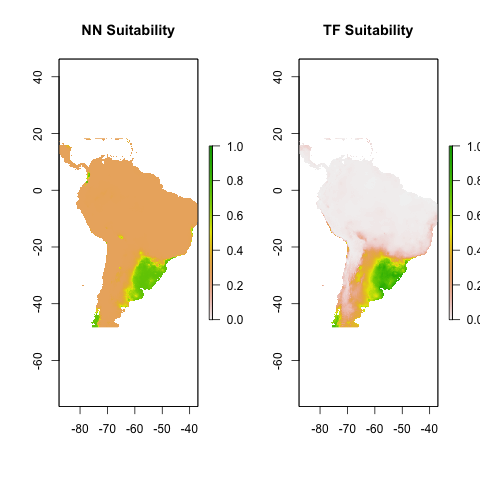

In [29]:
%%R
par(mfrow = c(1, 2))
plot(model_env$NN_prob, zlim = c(0, 1))
title("NN Suitability")
plot(model_env$TF_prob, zlim = c(0, 1))
title("TF Suitability")

In both plots, we see a similar "core" region of high confidence surrounded by a band of moderate confidence. However, our simple neural net predicts that essentially the rest of South America is equally likely to be inhabited by *S. commersonii*, which I find quite unlikely. The TF neural net, on the other hand, suggests it is extremely unlikely *S. commersonii* is found throughout the northern half of South America.

Despite these difference, plotting the absolute difference of the two models' thresholded predictions reveals they make very similar decisions overall.

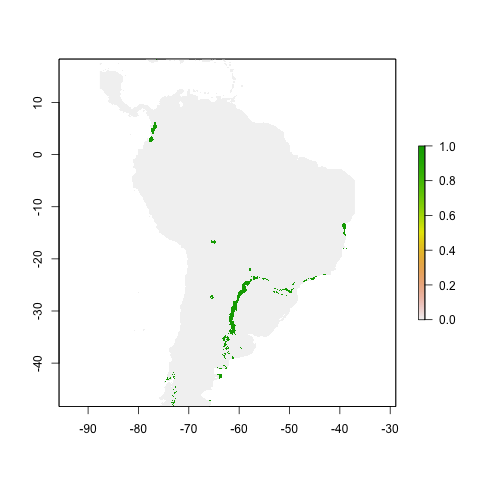

In [30]:
%%R
plot(abs((model_env$NN_prob > 0.5) - (model_env$TF_prob > 0.5)))

It is also interesting that both models suggest the coast near the southern tip of South America could be inhabitable to *S. commersonii* despite no observed presences there. Overall, I would prefer the TF neural net trained with early stopping since (1) it performs slightly better on the test set and (2) does not claim that half of South America is equally likely to be suitable for *S. commersonii*.

It is a great testament to the predictive power of neural networks that the TF neural net with early stopping outperformed all boosting methods while trained on *less* data. In the end, we have used neural networks to produce reasonable distribution maps for *s. commersonii*, and seen that they appear to outperform boosting methods for this particular species.